In [35]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using Random
using BlackBoxOptim
include("unicycle_env.jl")
include("controller.jl")
include("problem.jl")
include("safe_set.jl")

grad_phi (generic function with 2 methods)

In [36]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obs_radius = 0.5

0.5

In [37]:
function generate_moving_target(;fps=10, tf=2, v=nothing, v_lim=0.5)
    T = tf*fps
    v = isnothing(v) ? [rand(), rand()]*v_lim*2 .- v_lim : v
    p = [0, 1.5]
    return [Obstacle(p+v*(i/fps), v, obs_radius) for i in 0:T-1]
end

function get_Xref(x0, xg, T, dt)
    tf = T*dt
    dp = [xg[1]-x0[1], xg[2]-x0[2]]
    da = xg[4]-x0[4]
    a = atan(dp[2], dp[1])
    v = norm(dp)/tf
    v = max(min(v, 1),-1)
    vx = v * cos(a)
    vy = v * sin(a)
    Xref = [[x0[1]+vx*k*dt, x0[2]+vy*k*dt, v, a] for k = 1:T]
    Xref[end][3] = 0
    return Xref
end

function tracking(rp::RP, ctrl; fps=10, tf=2, obstacles=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    col_cnt = 0
    infeas=false
    for i in 1:T-1
        Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=obstacles, safety_index=safety_index)
        u, safe_set = timed_result.value
        if isnothing(u)
            u = i == 1 ? [0.,0.] : U[i-1]
            infeas=true
#             return X[1:i], U[1:i-1], safe_sets, Xrefs, true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(x, obstacle)
            @show p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
        if norm(x[1:2] - rp.xg[1:2]) < 0.1
            return X[1:i+1], U[1:i], safe_sets[1:i], Xrefs[1:i], infeas
        end
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

tracking (generic function with 1 method)

In [38]:
function collision_samples()
    nx = 20
    ny = 20
    nv = 10
    nt = 10
    xs = range(0,stop=5,length=nx)
    ys = range(0,stop=5,length=ny)
    vs = range(-2,stop=2,length=nv)
    θs = range(-π,stop=π,length=nt)
    samples = [([x,y,v,θ],[Obstacle([0.0, 0.0],[0,0],obs_radius)]) for x in xs, y in ys, v in vs, θ in θs];
    return samples
end
col_samples = collision_samples();

In [39]:
function exists_valid_control(safety_index, ctrl::ShootingController, x, obs, net, dt)
    safe_set = phi_safe_set(safety_index, x, obs, dt)
    for j in 1:ctrl.num_sample
        u_cand = rand(2) .* ctrl.u_lim * 2 - ctrl.u_lim
        dot_x_cand = compute_output(net, [x; u_cand])
        dot_x_cand ∈ safe_set && (return true)
    end
    return false
end

function eval_collision_index(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in col_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        valid += exists_valid_control(index, ctrl, x, obs, net, dt)
    end
    return Float64(length(col_samples)-valid)
end

eval_collision_index (generic function with 1 method)

In [14]:
Random.seed!(0)
res = bboptimize(eval_collision_index; SearchRange = [(0.1, 0.5), (1e-3, 2e-2), (0.1, 3.0), (0.1, 2.0)], TraceMode=:verbose, MaxFuncEvals=4);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
3.69 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=0.000000000
DE modify state:
38.50 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=0.000000000
DE modify state:

Optimization stopped after 3 steps and 50.13 seconds
Termination reason: Max number of function evaluations (4) reached
Steps per second = 0.06
Function evals per second = 0.12
Improvements/step = Inf
Total function evaluations = 6


Best candidate found: [0.12037, 0.0186236, 0.157352, 0.521703]

Fitness: 0.000000000



In [82]:
Random.seed!(1)
res = bboptimize(eval_collision_index; SearchRange = [(0.1, 0.5), (1e-3, 2e-2), (0.5, 3.0), (0.1, 2.0)], TraceMode=:verbose, MaxFuncEvals=10);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
23.38 secs, 2 evals, 1 steps, fitness=0.000000000
DE modify state:
49.63 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=0.000000000
DE modify state:
80.77 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 1.0000), fitness=0.000000000
DE modify state:
114.57 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 1.0000), fitness=0.000000000
DE modify state:
151.59 secs, 10 evals, 5 steps, improv/step: 0.800 (last = 1.0000), fitness=0.000000000
DE modify state:

Optimization stopped after 6 steps and 154.26 seconds
Termination reason: Max number of function evaluations (10) reached
Steps per second = 0.04
Function evals per second = 0.08
Improvements/step = Inf
Total function evaluations = 12


Best candidate found: [0.728854, 0.00915763, 0.277308, 1.05736

In [40]:
function draw_heat_plot(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in col_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        valid += exists_valid_control(index, ctrl, x, obs, net, dt)
    end
    return Float64(length(col_samples)-valid)
end

function find_infeas_states(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    infeas_states = Dict()
    infeas_map = zeros(size(col_samples)[1:2])
    for (idx, sample) in pairs(col_samples)
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        feas = exists_valid_control(index, ctrl, x, obs, net, dt)
        valid += feas
        feas && continue
        haskey(infeas_states, (idx[1], idx[2])) || (infeas_states[(idx[1], idx[2])] = [])
        push!(infeas_states[(idx[1], idx[2])], sample)
        infeas_map[idx[1], idx[2]] += 1
    end
    return Float64(length(col_samples)-valid), infeas_states, infeas_map
end

find_infeas_states (generic function with 1 method)

In [16]:
best_candidate(res)

4-element Array{Float64,1}:
 0.12037005385555011
 0.01862356097257451
 0.15735219089617197
 0.5217034068882422

In [23]:
infeas_cnt0, infeas_states0, infeas_map0 = find_infeas_states([0.0, 1e-3, 1, 0]);

In [36]:
@show infeas_cnt0
infeas_map = infeas_map0[1:15, 1:15]
heatmap((1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))
savefig("../results/heatmap0.png")

infeas_cnt0 = 256.0


In [35]:
@show infeas_cnt1
infeas_map = infeas_map1[1:15, 1:15]
heatmap((1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))
savefig("../results/heatmap1.png")

infeas_cnt1 = 477.0


In [21]:
infeas_cnt2, infeas_states2, infeas_map2 = find_infeas_states([0.4414972796097171, 0.009026466785366772, 0.5477213165593641, 2.8919496714508557]);

In [32]:
@show infeas_cnt2
infeas_map = infeas_map2[1:15, 1:15]
heatmap((1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))
savefig("../results/heatmap2.png")

infeas_cnt2 = 0.0


In [17]:
infeas_cnt3, infeas_states3, infeas_map3 = find_infeas_states([0.12037, 0.0186236, 0.157352, 0.521703])

(0.0, Dict{Any,Any}(), [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

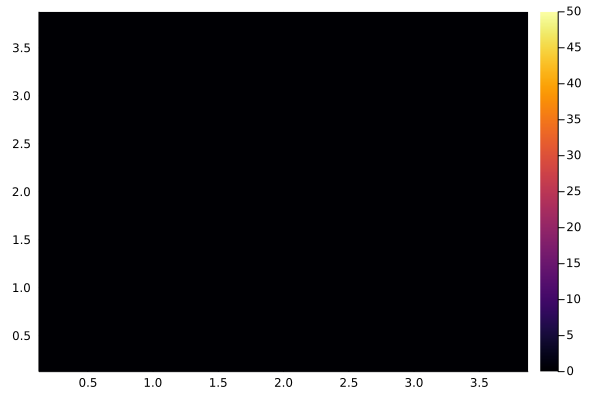

In [19]:
infeas_map = infeas_map3[1:15, 1:15]
heatmap((1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))

In [41]:
function collision_stat(num, ci; ctrl=nothing, verbose=false)
    Random.seed!(127)
    success = 0
    phi0_vio_cnt = 0
    infeas_cnt = 0
    x0 = [0,-1.5,1+rand(),π/2+rand()*π/2-π/4]
    xg = [0,5,0,-π]
    obj_cost = [1,1,1,0.1]
    rp = RP(net, obj_cost, x0, xg)
    n = 2
    for j in 1:num
        obstacles = [Obstacle([0, rand()-0.5], [0, 0], obs_radius)]
        ctrl = isnothing(ctrl) ? ShootingController(1000) : ctrl
        Xtrack, Utrack, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=10, obstacles=obstacles, safety_index=ci, verbose=false);
        infeas_cnt += infeas
        vio=false
        for obs in obstacles
            for x in Xtrack
                if norm(x[1:2]-obs.center) < obs.radius
                    vio=true
                    break
                end 
            end
        end
        phi0_vio_cnt += vio
#         success += norm(xg[1:2] - Xtrack[end][1:2]) < 0.1
        success += 1-(vio|infeas)
        if verbose
            @show j, success, phi0_vio_cnt, infeas_cnt
        end
    end
#     return success*1.0/num, phi0_vio_cnt, infeas_cnt*1.0/num
    return success*1.0/num, phi0_vio_cnt*1.0/num, infeas_cnt*1.0/num
end

collision_stat (generic function with 1 method)

In [121]:
ci = CollisionIndex(0.0, 1e-3, 1, 0)
collision_stat(100, ci)

(0.0, 1.0, 1.0)

In [120]:
ci = CollisionIndex(0.1, 1e-3, 2, 1)
collision_stat(100, ci)

(0.72, 0.0, 0.28)

In [118]:
ci = CollisionIndex(0.728854, 0.00915763, 0.277308, 1.05736)
collision_stat(100, ci)

(1.0, 0.0, 0.0)

In [21]:
ci = CollisionIndex(0.12037, 0.0186236, 0.157352, 0.521703)
collision_stat(100, ci)

(0.99, 0.01, 0.0)

In [22]:
ci = CollisionIndex(0.0, 1e-3, 1, 0)
collision_stat(100, ci)

(0.0, 1.0, 1.0)

In [23]:
ci = CollisionIndex(0.1, 1e-3, 2, 1)
collision_stat(100, ci)

(0.72, 0.0, 0.28)

In [42]:

function gt_tracking(rp::RP, ctrl; fps=10, tf=2, obstacles=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    col_cnt = 0
    infeas=false
    for i in 1:T-1
        Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=obstacles, safety_index=safety_index)
        u, safe_set = timed_result.value
        if isnothing(u)
            u = i == 1 ? [0.,0.] : U[i-1]
            infeas=true
#             return X[1:i], U[1:i-1], safe_sets, Xrefs, true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(x, obstacle)
            @show p
        end
        x = forward(x, u, dt)
        X[i+1] = x
        U[i] = u
        if norm(x[1:2] - rp.xg[1:2]) < 0.1
            return X[1:i+1], U[1:i], safe_sets[1:i], Xrefs[1:i], infeas
        end
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

function gt_collision_stat(num, ci; ctrl=nothing, verbose=false)
    Random.seed!(127)
    success = 0
    phi0_vio_cnt = 0
    infeas_cnt = 0
    x0 = [0,-1.5,1+rand(),π/2+rand()*π/2-π/4]
    xg = [0,5,0,-π]
    obj_cost = [1,1,1,0.1]
    rp = RP(net, obj_cost, x0, xg)
    n = 2
    for j in 1:num
        obstacles = [Obstacle([0, rand()-0.5], [0, 0], obs_radius)]
        ctrl = isnothing(ctrl) ? ShootingController(1000) : ctrl
        Xtrack, Utrack, safe_sets, Xrefs, infeas = gt_tracking(rp, ctrl, fps=10, tf=10, obstacles=obstacles, safety_index=ci, verbose=false);
        infeas_cnt += infeas
        vio=false
        for obs in obstacles
            for x in Xtrack
                if norm(x[1:2]-obs.center) < obs.radius
                    vio=true
                    break
                end 
            end
        end
        phi0_vio_cnt += vio
#         success += norm(xg[1:2] - Xtrack[end][1:2]) < 0.1
        success += 1-(vio|infeas)
        if verbose
            @show j, success, phi0_vio_cnt, infeas_cnt
        end
    end
#     return success*1.0/num, phi0_vio_cnt, infeas_cnt*1.0/num
    return success*1.0/num, phi0_vio_cnt*1.0/num, infeas_cnt*1.0/num
end

gt_collision_stat (generic function with 1 method)

In [30]:
ci = CollisionIndex(0.0, 1e-3, 1, 0)
gt_collision_stat(100, ci)

(0.0, 1.0, 1.0)

In [31]:
ci = CollisionIndex(0.1, 1e-3, 2, 1)
gt_collision_stat(100, ci)

(0.65, 0.0, 0.35)

In [32]:
ci = CollisionIndex(0.728854, 0.00915763, 0.277308, 1.05736)
gt_collision_stat(100, ci)

(0.79, 0.21, 0.0)

In [43]:
ci = CollisionIndex(0.743431, 0.00915763, 0.277308, 1.05736)
gt_collision_stat(100, ci)

(0.77, 0.23, 0.0)

In [44]:
ci = CollisionIndex(0.765296, 0.00915763, 0.277308, 1.05736)
gt_collision_stat(100, ci)

(0.79, 0.21, 0.0)

In [45]:
ci = CollisionIndex(0.85, 0.00915763, 0.277308, 1.05736)
gt_collision_stat(100, ci)

(0.7, 0.3, 0.0)

In [ ]:
ci = CollisionIndex(0.85, 0.00915763, 0.277308, 1.05736)
gt_collision_stat(100, ci)